# Sleep Quality Prediction with a Transformer
Prepared automatically by ChatGPT – edit and expand as needed.

In [1]:
import gc
import torch

# Delete any existing variables that may be using memory
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

# Run garbage collection
gc.collect()

# If using GPU, clear CUDA cache (safe to call even if not using CUDA)
torch.cuda.empty_cache()

NameError: name 'gc' is not defined

In [1]:
import sys
print(sys.executable)

/home/juhyeong/.conda/envs/tf216/bin/python


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-06-04 14:47:01.797364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 14:47:01.811289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749016021.829840 3456227 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749016021.835914 3456227 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 14:47:01.855545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: NVIDIA RTX A6000


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
!pip install tqdm

In [7]:
import sys
print(sys.executable)

/home/juhyeong/.conda/envs/tf216/bin/python


In [8]:

import pandas as pd
import numpy as np
import os, glob, math
from pathlib import Path
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score


In [9]:
DATA_DIR = Path('/home/juhyeong/20251R0136COSE47101/data')
attribute_files = sorted([p for p in DATA_DIR.glob('ch2025_*[!metrics]*.parquet')])
print('Attribute Parquets:', len(attribute_files))
for p in attribute_files:
    print('-', p.name)

metrics_path = DATA_DIR / 'ch2025_metrics_train.csv'
metrics_df = pd.read_csv(metrics_path)
metrics_df.head()


Attribute Parquets: 12
- ch2025_mACStatus.parquet
- ch2025_mActivity.parquet
- ch2025_mAmbience.parquet
- ch2025_mBle.parquet
- ch2025_mGps.parquet
- ch2025_mLight.parquet
- ch2025_mScreenStatus.parquet
- ch2025_mUsageStats.parquet
- ch2025_mWifi.parquet
- ch2025_wHr.parquet
- ch2025_wLight.parquet
- ch2025_wPedo.parquet


,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-06-27,2024-06-26,0,0,0,0,0,1
1,id01,2024-06-28,2024-06-27,0,0,0,0,1,1
2,id01,2024-06-29,2024-06-28,1,0,0,1,1,1
3,id01,2024-06-30,2024-06-29,1,0,1,2,0,0
4,id01,2024-07-01,2024-06-30,0,1,1,1,1,1


In [10]:
def load_attribute_parquet(path: Path, ts_col='timestamp', subj_col='subject_id'):
    df = pd.read_parquet(path)
    # Display data for debugging
    print(f"--- {path.name} HEAD ---")
    print(df.head())
    print(df.dtypes)

    if ts_col not in df.columns:
        raise ValueError(f'{ts_col} not found in {path.name}')
    df[ts_col] = pd.to_datetime(df[ts_col])
    df['date'] = df[ts_col].dt.floor('d')
    df = df.set_index(ts_col)

    # Coerce all columns except subject_id and date to numeric
    for col in df.columns:
        if col not in [subj_col, 'date']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Now select only numeric columns
    value_cols = [c for c in df.columns if c not in [subj_col, 'date'] and pd.api.types.is_numeric_dtype(df[c])]
    print("Numeric columns detected:", value_cols)
    if not value_cols:
        print(f"Warning: {path.name} has no numeric columns after conversion, skipping.")
        return None

    # Prefix value columns for uniqueness
    df_prefixed = df[value_cols].rename(columns={c: f'{path.stem}_{c}' for c in value_cols})
    # Add subject_id and date for grouping later
    df_prefixed[subj_col] = df[subj_col]
    df_prefixed['date'] = df['date']
    return df_prefixed

In [13]:
from collections import defaultdict

day_frames = defaultdict(list)
for parquet_path in tqdm(attribute_files):
    df_attr = load_attribute_parquet(parquet_path)
    if df_attr is None:
        continue  # skip files with no numeric features
    for (subj, day), grp in df_attr.groupby(['subject_id', 'date']):
        # Drop grouping columns
        feature_cols = [c for c in grp.columns if c not in ['subject_id', 'date']]
        day_frames[(subj, day)].append(grp[feature_cols])

feature_names = None
sequences = []
targets = []

for idx, row in metrics_df.iterrows():
    subj = row['subject_id']
    day = pd.to_datetime(row['lifelog_date']).floor('d')  # ensure Timestamp, floored to day
    key = (subj, day)
    day_ts = day
    # Create 1-min grid
    day_index = pd.date_range(day_ts, day_ts + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='1min')
    if key in day_frames and day_frames[key]:
        merged = pd.concat(day_frames[key], axis=1)
        merged = merged.reindex(day_index)
    else:
        merged = pd.DataFrame(index=day_index)
    print(f"Key: {key}, merged shape: {merged.shape}, columns: {list(merged.columns)}")  # Debug print
    # Set feature_names to the full set of columns from the first valid merged
    if feature_names is None and merged.shape[1] > 0:
        feature_names = merged.columns.tolist()
    # Always reindex columns to feature_names, filling missing with 0
    if feature_names is not None:
        merged = merged.reindex(columns=feature_names, fill_value=0)
    merged = merged.ffill().bfill().fillna(0)
    if merged.shape[1] > 0:
        sequences.append(merged.values.astype(np.float32))
        targets.append(row[['Q1','Q2','Q3','S1','S2','S3']].values.astype(np.float32))
    else:
        print(f"Warning: No features for {key}, skipping this sequence.")

# Final shape check
print("Feature names:", feature_names)
print("Number of sequences:", len(sequences))
print("Shape of first sequence:", sequences[0].shape if sequences else "None")
if len(sequences) == 0:
    raise RuntimeError("No valid sequences found. Check your data and key matching logic.")
X = np.stack(sequences)  # shape [N, 1440, F]
y = np.stack(targets)     # shape [N, 6]
print('Data tensor shape:', X.shape, y.shape)

  0%|          | 0/12 [00:00<?, ?it/s]

--- ch2025_mACStatus.parquet HEAD ---
  subject_id           timestamp  m_charging
0       id01 2024-06-26 12:03:00           0
1       id01 2024-06-26 12:04:00           0
2       id01 2024-06-26 12:05:00           0
3       id01 2024-06-26 12:06:00           0
4       id01 2024-06-26 12:07:00           0
subject_id            object
timestamp     datetime64[ns]
m_charging             int64
dtype: object
Numeric columns detected: ['m_charging']


  8%|▊         | 1/12 [00:00<00:08,  1.23it/s]

--- ch2025_mActivity.parquet HEAD ---
  subject_id           timestamp  m_activity
0       id01 2024-06-26 12:03:00           4
1       id01 2024-06-26 12:04:00           0
2       id01 2024-06-26 12:05:00           0
3       id01 2024-06-26 12:06:00           0
4       id01 2024-06-26 12:07:00           0
subject_id            object
timestamp     datetime64[ns]
m_activity             int64
dtype: object
Numeric columns detected: ['m_activity']


 17%|█▋        | 2/12 [00:01<00:07,  1.28it/s]

--- ch2025_mAmbience.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 13:00:10   
1       id01 2024-06-26 13:02:10   
2       id01 2024-06-26 13:04:10   
3       id01 2024-06-26 13:06:10   
4       id01 2024-06-26 13:08:10   

                                          m_ambience  
0  [[Music, 0.30902618], [Vehicle, 0.081680894], ...  
1  [[Music, 0.62307084], [Vehicle, 0.021118319], ...  
2  [[Horse, 0.25209898], [Animal, 0.24263993], [C...  
3  [[Speech, 0.93433166], [Inside, large room or ...  
4  [[Speech, 0.8935082], [Inside, small room, 0.0...  
subject_id            object
timestamp     datetime64[ns]
m_ambience            object
dtype: object
Numeric columns detected: ['m_ambience']


 25%|██▌       | 3/12 [00:05<00:18,  2.02s/it]

--- ch2025_mBle.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 12:13:00   
1       id01 2024-06-26 12:23:00   
2       id01 2024-06-26 12:33:00   
3       id01 2024-06-26 13:23:00   
4       id01 2024-06-26 14:23:00   

                                               m_ble  
0  [{'address': '00:15:7C:11:80:8D', 'device_clas...  
1  [{'address': '0A:B1:26:4D:76:21', 'device_clas...  
2  [{'address': '04:F5:AE:39:95:E0', 'device_clas...  
3  [{'address': '06:C0:D2:6D:9F:69', 'device_clas...  
4  [{'address': '10:2B:41:74:9F:B1', 'device_clas...  
subject_id            object
timestamp     datetime64[ns]
m_ble                 object
dtype: object
Numeric columns detected: ['m_ble']


 33%|███▎      | 4/12 [00:06<00:13,  1.74s/it]

--- ch2025_mGps.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 12:03:00   
1       id01 2024-06-26 12:04:00   
2       id01 2024-06-26 12:05:00   
3       id01 2024-06-26 12:06:00   
4       id01 2024-06-26 12:07:00   

                                               m_gps  
0  [{'altitude': 110.6, 'latitude': 0.2077385, 'l...  
1  [{'altitude': 110.8, 'latitude': 0.2078068, 'l...  
2  [{'altitude': 110.7, 'latitude': 0.2078214, 'l...  
3  [{'altitude': 110.7, 'latitude': 0.2078395, 'l...  
4  [{'altitude': 110.8, 'latitude': 0.2078478, 'l...  
subject_id            object
timestamp     datetime64[ns]
m_gps                 object
dtype: object
Numeric columns detected: ['m_gps']


 42%|████▏     | 5/12 [00:16<00:32,  4.62s/it]

--- ch2025_mLight.parquet HEAD ---
  subject_id           timestamp  m_light
0       id01 2024-06-26 12:03:00    534.0
1       id01 2024-06-26 12:13:00    846.0
2       id01 2024-06-26 12:23:00    826.0
3       id01 2024-06-26 12:33:00    851.0
4       id01 2024-06-26 12:43:00    428.0
subject_id            object
timestamp     datetime64[ns]
m_light              float64
dtype: object
Numeric columns detected: ['m_light']


 50%|█████     | 6/12 [00:16<00:18,  3.15s/it]

--- ch2025_mScreenStatus.parquet HEAD ---
  subject_id           timestamp  m_screen_use
0       id01 2024-06-26 12:03:00             0
1       id01 2024-06-26 12:04:00             0
2       id01 2024-06-26 12:05:00             0
3       id01 2024-06-26 12:06:00             0
4       id01 2024-06-26 12:07:00             0
subject_id              object
timestamp       datetime64[ns]
m_screen_use             int64
dtype: object
Numeric columns detected: ['m_screen_use']


 58%|█████▊    | 7/12 [00:16<00:11,  2.30s/it]

--- ch2025_mUsageStats.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 13:00:00   
1       id01 2024-06-26 13:10:00   
2       id01 2024-06-26 13:20:00   
3       id01 2024-06-26 13:30:00   
4       id01 2024-06-26 13:50:00   

                                       m_usage_stats  
0  [{'app_name': ' 캐시워크', 'total_time': 69}, {'ap...  
1  [{'app_name': '통화', 'total_time': 26419}, {'ap...  
2  [{'app_name': '메시지', 'total_time': 388651}, {'...  
3  [{'app_name': '메시지', 'total_time': 211633}, {'...  
4  [{'app_name': '카카오톡', 'total_time': 35446}, {'...  
subject_id               object
timestamp        datetime64[ns]
m_usage_stats            object
dtype: object
Numeric columns detected: ['m_usage_stats']


 67%|██████▋   | 8/12 [00:17<00:06,  1.72s/it]

--- ch2025_mWifi.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 12:03:00   
1       id01 2024-06-26 12:13:00   
2       id01 2024-06-26 12:23:00   
3       id01 2024-06-26 12:33:00   
4       id01 2024-06-26 12:43:00   

                                              m_wifi  
0  [{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ...  
1  [{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ...  
2  [{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ...  
3  [{'bssid': '10:e3:c7:09:7f:bc', 'rssi': -80}, ...  
4  [{'bssid': '56:46:ae:59:b1:13', 'rssi': -44}, ...  
subject_id            object
timestamp     datetime64[ns]
m_wifi                object
dtype: object
Numeric columns detected: ['m_wifi']


 75%|███████▌  | 9/12 [00:18<00:04,  1.61s/it]

--- ch2025_wHr.parquet HEAD ---
  subject_id           timestamp  \
0       id01 2024-06-26 12:23:00   
1       id01 2024-06-26 12:24:00   
2       id01 2024-06-26 12:25:00   
3       id01 2024-06-26 12:26:00   
4       id01 2024-06-26 12:27:00   

                                          heart_rate  
0  [134, 134, 135, 133, 134, 135, 134, 135, 134, ...  
1  [123, 122, 121, 120, 121, 121, 120, 118, 119, ...  
2  [120, 119, 117, 116, 119, 121, 123, 123, 121, ...  
3  [125, 124, 124, 124, 125, 124, 124, 123, 123, ...  
4  [116, 116, 117, 118, 116, 116, 116, 117, 115, ...  
subject_id            object
timestamp     datetime64[ns]
heart_rate            object
dtype: object
Numeric columns detected: ['heart_rate']


 83%|████████▎ | 10/12 [00:20<00:03,  1.62s/it]

--- ch2025_wLight.parquet HEAD ---
  subject_id           timestamp  w_light
0       id01 2024-06-26 12:17:00    633.0
1       id01 2024-06-26 12:18:00    483.0
2       id01 2024-06-26 12:19:00    541.0
3       id01 2024-06-26 12:20:00    547.0
4       id01 2024-06-26 12:21:00    547.0
subject_id            object
timestamp     datetime64[ns]
w_light              float64
dtype: object
Numeric columns detected: ['w_light']


 92%|█████████▏| 11/12 [00:21<00:01,  1.38s/it]

--- ch2025_wPedo.parquet HEAD ---
  subject_id           timestamp  step  step_frequency  running_step  \
0       id01 2024-06-26 12:09:00    10        0.166667             0   
1       id01 2024-06-26 12:10:00     0        0.000000             0   
2       id01 2024-06-26 12:11:00     0        0.000000             0   
3       id01 2024-06-26 12:12:00     0        0.000000             0   
4       id01 2024-06-26 12:13:00     0        0.000000             0   

   walking_step  distance     speed  burned_calories  
0             0      8.33  0.138833              0.0  
1             0      0.00  0.000000              0.0  
2             0      0.00  0.000000              0.0  
3             0      0.00  0.000000              0.0  
4             0      0.00  0.000000              0.0  
subject_id                 object
timestamp          datetime64[ns]
step                        int64
step_frequency            float64
running_step                int64
walking_step                int64

100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Key: ('id01', Timestamp('2024-06-26 00:00:00')), merged shape: (1440, 18), columns: ['ch2025_mACStatus_m_charging', 'ch2025_mActivity_m_activity', 'ch2025_mAmbience_m_ambience', 'ch2025_mBle_m_ble', 'ch2025_mGps_m_gps', 'ch2025_mLight_m_light', 'ch2025_mScreenStatus_m_screen_use', 'ch2025_mUsageStats_m_usage_stats', 'ch2025_mWifi_m_wifi', 'ch2025_wHr_heart_rate', 'ch2025_wLight_w_light', 'ch2025_wPedo_step', 'ch2025_wPedo_step_frequency', 'ch2025_wPedo_running_step', 'ch2025_wPedo_walking_step', 'ch2025_wPedo_distance', 'ch2025_wPedo_speed', 'ch2025_wPedo_burned_calories']
Key: ('id01', Timestamp('2024-06-27 00:00:00')), merged shape: (1440, 18), columns: ['ch2025_mACStatus_m_charging', 'ch2025_mActivity_m_activity', 'ch2025_mAmbience_m_ambience', 'ch2025_mBle_m_ble', 'ch2025_mGps_m_gps', 'ch2025_mLight_m_light', 'ch2025_mScreenStatus_m_screen_use', 'ch2025_mUsageStats_m_usage_stats', 'ch2025_mWifi_m_wifi', 'ch2025_wHr_heart_rate', 'ch2025_wLight_w_light', 'ch2025_wPedo_step', 'ch2025_

In [17]:
display(X)

array([[[0.        , 4.        , 0.        , ..., 8.33      ,
         0.13883333, 0.        ],
        [0.        , 4.        , 0.        , ..., 8.33      ,
         0.13883333, 0.        ],
        [0.        , 4.        , 0.        , ..., 8.33      ,
         0.13883333, 0.        ],
        ...,
        [0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 4.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 3.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [18]:
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    np.arange(len(X)),
    test_size=0.3,
    random_state=42,
    stratify=y[:,4]   # S1 column
)
scaler = StandardScaler()
# Fit on training data (flattened)
scaler.fit(X[train_idx].reshape(-1, X.shape[-1]))
X_scaled = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

In [ ]:
class DayDataset(Dataset):
    def __init__(self, X, y, indices):
        self.X = torch.from_numpy(X[indices])  # shape [N, T, F]
        self.y = torch.from_numpy(y[indices])
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32
train_ds = DayDataset(X_scaled, y, train_idx)
val_ds = DayDataset(X_scaled, y, val_idx)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1440):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        x = x + self.pe[:, :x.size(1)]
        return x

In [26]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1440):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        x = x + self.pe[:, :x.size(1)]
        return x

In [27]:
class TransformerSleep(nn.Module):
    def __init__(self, feat_dim, n_targets, d_model=128, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(feat_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, n_targets)
        )
        self.positional_encoding = PositionalEncoding(d_model, max_len=1440)
    def forward(self, x):  # x [B,T,F]
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        enc = self.encoder(x)              # shape [B,T,d_model]
        pooled = enc.mean(dim=1)           # simple average pooling
        out = self.classifier(pooled)      # [B, n_targets]
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerSleep(X.shape[-1], y.shape[-1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [23]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 4)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    # Re-create model and optimizer
    model = TransformerSleep(X.shape[-1], y.shape[-1], d_model=d_model, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Re-create DataLoader with new batch size
    train_ds = DayDataset(X_scaled, y, train_idx)
    val_ds = DayDataset(X_scaled, y, val_idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Train for a few epochs (e.g., 3 for speed)
    for epoch in range(3):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
    # Evaluate
    val_auc, _ = evaluate(val_loader)
    return val_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-04 15:00:38,334] A new study created in memory with name: no-name-67f2e655-40cf-482f-8f32-2641bdc9fdfe


/tmp/ipykernel_3456227/4294792853.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-06-04 15:00:41,150] Trial 0 finished with value: 0.5613469765760665 and parameters: {'d_model': 128, 'num_layers': 3, 'lr': 0.00032886537518126715, 'batch_size': 32}. Best is trial 0 with value: 0.5613469765760665.
/tmp/ipykernel_3456227/4294792853.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-06-04 15:00:44,458] Trial 1 finished with value: 0.5613469765760665 and parameters: {'d_model': 64, 'num_layers': 4, 'lr': 0.004969797827464208, 'batch_size': 8}. Best is trial 0 

Best trial:
  Value: 0.5613469765760665
  Params: 
    d_model: 128
    num_layers: 3
    lr: 0.00032886537518126715
    batch_size: 32


In [ ]:
def evaluate(loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            ys.append(yb.cpu().numpy())
            preds.append(torch.sigmoid(logits).cpu().numpy())
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    # Binarize targets if not already 0/1
    if not np.array_equal(ys, ys.astype(bool)):
        ys_bin = (ys > 0.5).astype(int)
    else:
        ys_bin = ys.astype(int)
    try:
        auc = roc_auc_score(ys_bin, preds, average='macro')
        ap = average_precision_score(ys_bin, preds, average='macro')
    except ValueError as e:
        print("Evaluation error:", e)
        auc, ap = np.nan, np.nan
    return auc, ap

import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_aucs = []
val_aps = []

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_auc, val_ap = evaluate(val_loader)
    val_aucs.append(val_auc)
    val_aps.append(val_ap)
    print(f'E{epoch:02d}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, Val AUC={val_auc:.3f}, AP={val_ap:.3f}')


E01: Train Loss=0.6363, Val Loss=0.6291, Val AUC=0.526, AP=0.646
E02: Train Loss=0.6212, Val Loss=0.6209, Val AUC=0.533, AP=0.649
E03: Train Loss=0.6136, Val Loss=0.6202, Val AUC=0.557, AP=0.677
E04: Train Loss=0.6156, Val Loss=0.6165, Val AUC=0.568, AP=0.688
E05: Train Loss=0.5869, Val Loss=0.6570, Val AUC=0.514, AP=0.651


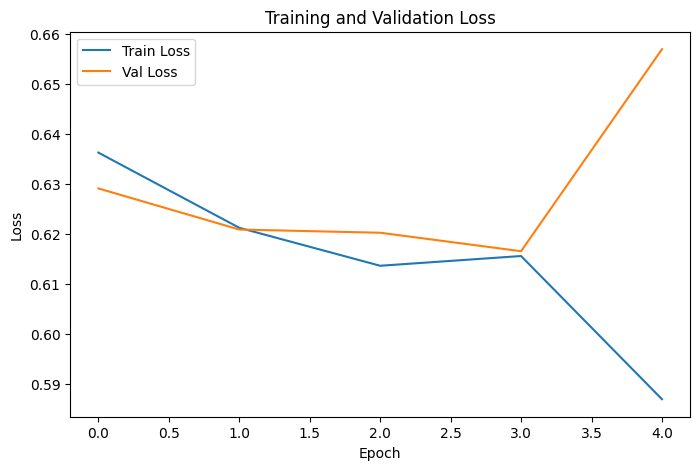

In [29]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

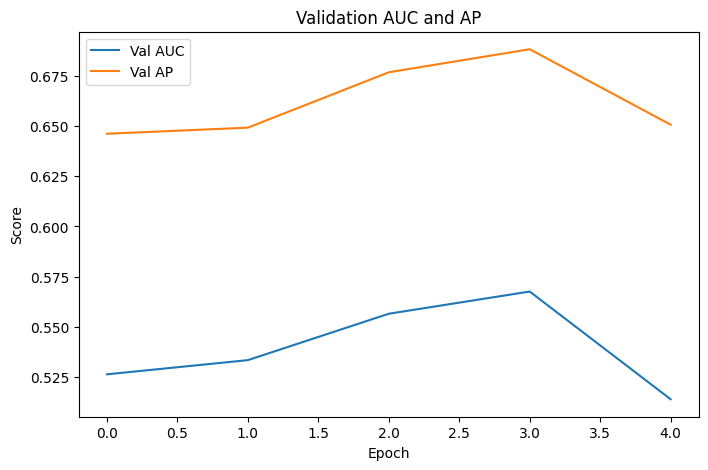

In [30]:
plt.figure(figsize=(8,5))
plt.plot(val_aucs, label='Val AUC')
plt.plot(val_aps, label='Val AP')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation AUC and AP')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load sample submission
sub_path = '/home/juhyeong/20251R0136COSE47101/Model test_1/ch2025_submission_sample.csv'
submission = pd.read_csv(sub_path)

# Prepare predictions
preds = []

model.eval()
with torch.no_grad():
    for idx, row in submission.iterrows():
        subj = row['subject_id']
        day = pd.to_datetime(row['lifelog_date']).floor('d')
        key = (subj, day)
        day_ts = day
        # Create 1-min grid
        day_index = pd.date_range(day_ts, day_ts + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='1min')
        if key in day_frames and day_frames[key]:
            merged = pd.concat(day_frames[key], axis=1)
            merged = merged.reindex(day_index)
        else:
            merged = pd.DataFrame(index=day_index)
        # Use the same feature_names as training
        if feature_names is not None:
            merged = merged.reindex(columns=feature_names, fill_value=0)
        merged = merged.ffill().bfill().fillna(0)
        # Scale features
        X_test = scaler.transform(merged.values.astype(np.float32))
        X_test = torch.from_numpy(X_test).unsqueeze(0).to(device)  # [1, 1440, F]
        # Predict
        logits = model(X_test)
        prob = torch.sigmoid(logits).cpu().numpy().flatten()
        preds.append(prob)

# Fill predictions into submission DataFrame
preds = np.array(preds)
submission[['Q1','Q2','Q3','S1','S2','S3']] = preds

# Save to CSV
submission.to_csv('submission.csv', index=False)
print('Saved submission.csv')

In [ ]:
import pandas as pd

submission = pd.read_csv('submission.csv')

# Binarize Q1, Q2, Q3, S2, S3
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission[col] = (submission[col] > 0.5).astype(int)

# S1: map to 0, 1, 2 based on value
# You can adjust the thresholds as needed
submission['S1'] = pd.cut(
    submission['S1'],
    bins=[-float('inf'), 0.33, 0.66, float('inf')],
    labels=[0, 1, 2]
).astype(int)

submission.to_csv('submission_fixed.csv', index=False)
print('Saved submission_fixed.csv')